# WGAN-GP - Wasserstein GAN



## Importing the libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.12.0'

## Loading and preprocessing the dataset

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

## Building the generator

- The same architecture of DCGAN

In [ ]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.3037068 ,  0.908766  ,  0.25527686,  0.9158066 ,  0.5463711 ,
         0.20958975,  0.05973865,  0.07107902,  0.6420049 ,  2.3585758 ,
         0.63244444,  0.5372597 , -0.5617043 ,  0.6417681 ,  1.9442816 ,
        -0.25777927, -0.08025274, -0.63961226,  1.9201086 , -2.3072736 ,
        -0.44119105, -0.78075427, -0.15281518,  0.34206346, -0.44209197,
        -1.1252002 ,  0.31743228,  0.15972061, -0.0757901 ,  0.38098383,
        -0.61503524, -0.06136658,  1.4064935 , -0.9475894 ,  0.7289527 ,
        -0.49874425, -1.1303279 ,  1.3049413 , -0.9817798 ,  1.0581975 ,
        -1.5280445 , -1.0535958 , -0.73941356, -1.6056575 , -0.6242986 ,
        -0.08114084, -1.1417632 ,  0.02767253,  0.8878435 ,  0.26290235,
         0.31504795,  0.06294689, -0.1234199 , -0.9400107 ,  0.6552003 ,
        -0.7602555 ,  0.7240004 ,  0.3890574 , -0.39361364, -0.7728545 ,
         1.4378899 , -1.1518409 ,  0.19713324, -0.73018956, -1.2477101 ,
 

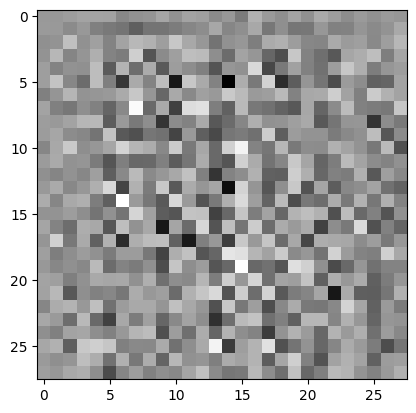

In [ ]:
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0, :,:,0], cmap='gray');

## Building the discriminator

- The discriminator is also called as "critic"

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00280557]], dtype=float32)>

In [ ]:
tf.sigmoid(-0.00030457)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49992383>


## Function to calculate **Wasserstein Loss**

The (*loss*) is the difference between the expected output of the discriminator for authentic images and the expected output of the discriminator for fake images (generated by the generator).

* The objective of the discriminator is to maximize this difference, while the objective of the generator is to minimize it.


In [ ]:
(0.2 + 0.9 + 0.99) / 3

0.6966666666666667

In [ ]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.99])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.6966667>

In [ ]:
def loss_generator(fake_output):
  g_loss = -1. * tf.math.reduce_mean(fake_output)
  return g_loss

In [ ]:
def loss_discriminator(real_output, fake_output, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- Beta parameters: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 To use Wasserstein loss, the discriminator must be **1-L** [(1-Lipschitz) continous](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt) - maximum 1.

To use 1-L we need **Gradient Penalty**.

This variation is called **WGAN-GP** (**G**radient **P**enalty)

(More information about Gradient Penalty [this article](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

[link text](https://)Steps to calculate gradient penalty:
1. Calculate an interpolated image from the real and fake image (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calculate the gradient of the discriminator output relative to the interpolated image. After, we calculate the gradient norm. Documentation: - tf.norm: https://www.tensorflow.org/api_docs/python/tf/norm
3. Finally, the penalty is calculated as an average of the square of (norm - 1), as we want the norm to be close to one.

We use [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [ ]:
3 ** 2

9

In [ ]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]
  gradient = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [ ]:
# 0.2 -> 0.02 -> 0.002

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
#print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
epochs = 30
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [ ]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 0.23401435,  0.89020777, -1.2553596 , ...,  0.8549396 ,
         1.3351656 , -0.09174924],
       [-0.00671193, -1.2569716 , -0.12031293, ..., -1.1454886 ,
         1.2484736 , -0.5819939 ],
       [ 0.13476275, -1.2578627 ,  0.35275036, ...,  0.39477044,
        -0.28587937,  0.2687162 ],
       ...,
       [ 0.51459414, -0.8560152 , -1.3222206 , ..., -0.7570106 ,
         0.45068455, -1.0174518 ],
       [ 0.54163724,  0.9524006 ,  1.3956367 , ...,  0.25237972,
        -0.9484807 , -0.6420284 ],
       [-1.9607432 ,  0.5955291 ,  0.5532617 , ..., -0.06305863,
         1.1538011 , -1.7315736 ]], dtype=float32)>

In [ ]:
def training_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminator_extra_steps = 3
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)
      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(images, generated_images, epsilon)

      d_loss = loss_discriminator(real_output, fake_output, gp)
    discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with tf.GradientTape() as g_tape:
    generated_images = generator(noise, training = True)
    fake_output = discriminator(generated_images, training = True)
    g_loss = loss_generator(fake_output)
  generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [ ]:
def create_and_save_images(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    initial = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        training_step(img_batch)
    #display.clear_output(wait = True)
    create_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken to process epoch {} was {} seconds'.format(epoch + 1, time.time() - initial))

  #display.clear_output(wait = True)
  create_and_save_images(generator, epochs, seed)
  generator.save('generator.h5')

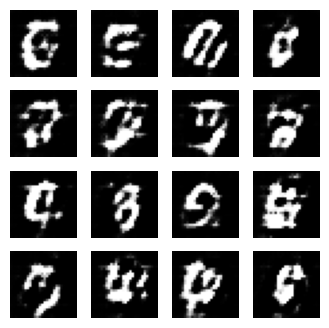

Time taken to process epoch 1 was 84.09189939498901 seconds


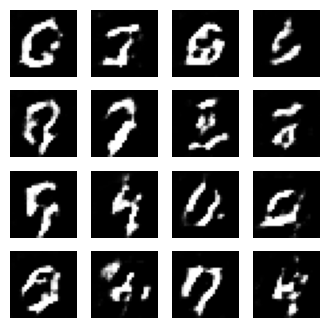

Time taken to process epoch 2 was 58.28963327407837 seconds


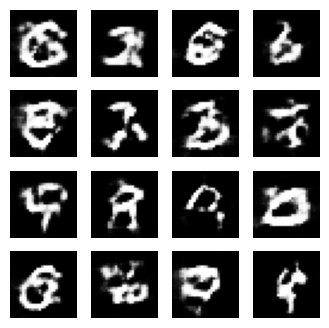

Time taken to process epoch 3 was 59.15068507194519 seconds


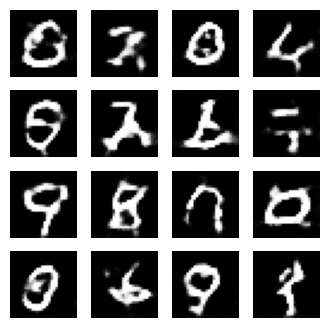

Time taken to process epoch 4 was 57.91148114204407 seconds


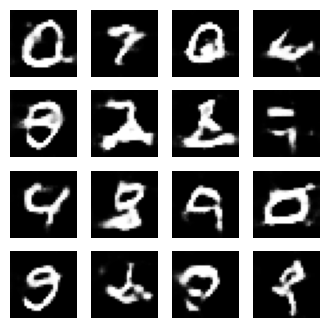

Time taken to process epoch 5 was 58.085389137268066 seconds


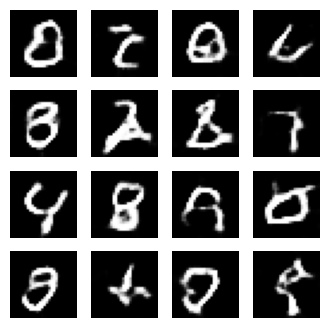

Time taken to process epoch 6 was 58.47852897644043 seconds


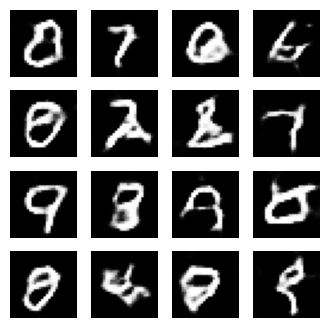

Time taken to process epoch 7 was 82.37254881858826 seconds


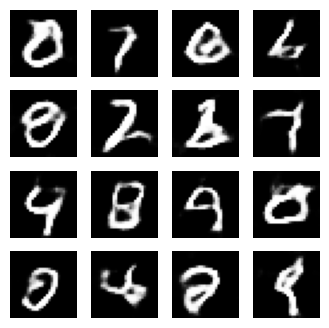

Time taken to process epoch 8 was 82.36501836776733 seconds


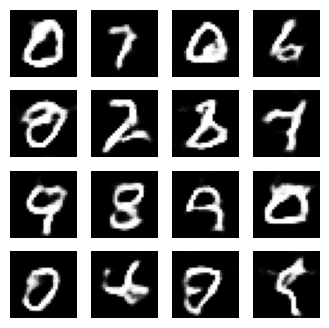

Time taken to process epoch 9 was 58.001548767089844 seconds


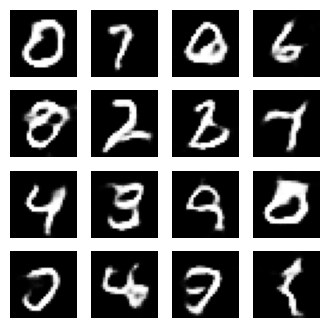

Time taken to process epoch 10 was 58.056692600250244 seconds


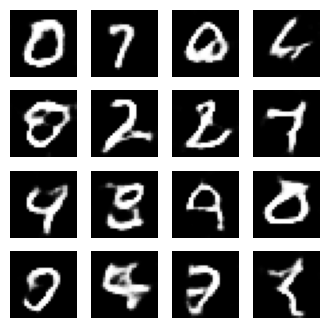

Time taken to process epoch 11 was 57.73116970062256 seconds


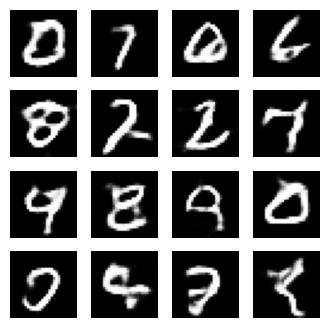

Time taken to process epoch 12 was 57.78226137161255 seconds


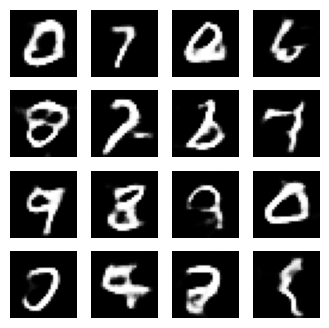

Time taken to process epoch 13 was 57.925026178359985 seconds


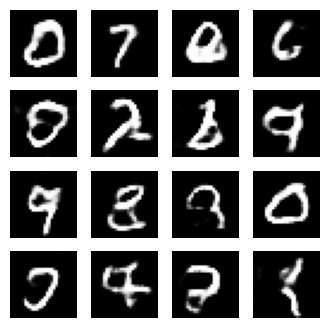

Time taken to process epoch 14 was 57.943923473358154 seconds


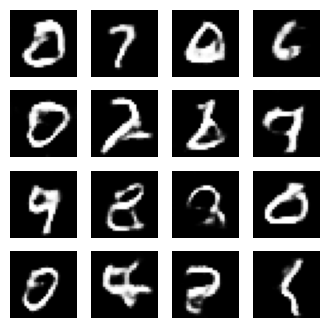

Time taken to process epoch 15 was 57.48659682273865 seconds


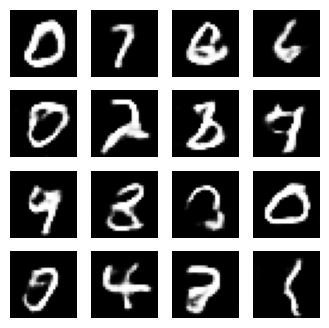

Time taken to process epoch 16 was 57.59256887435913 seconds


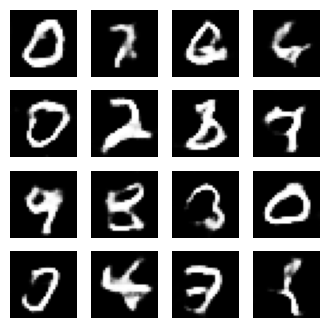

Time taken to process epoch 17 was 58.3518443107605 seconds


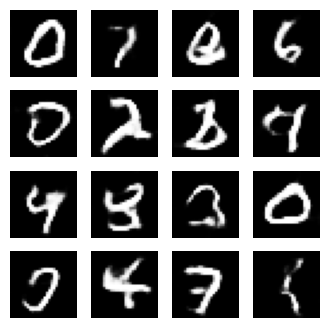

Time taken to process epoch 18 was 57.75244927406311 seconds


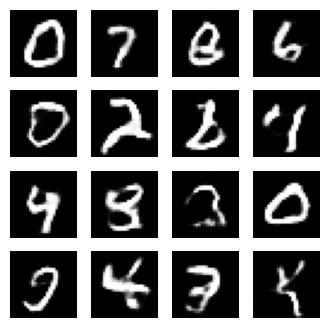

Time taken to process epoch 19 was 57.741127252578735 seconds


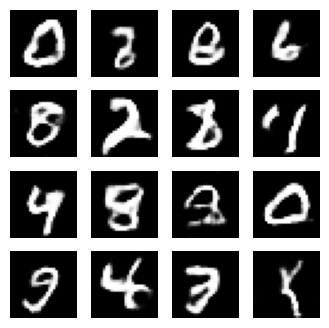

Time taken to process epoch 20 was 57.86531686782837 seconds


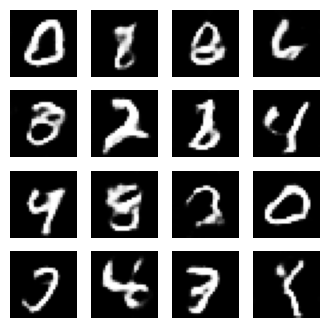

Time taken to process epoch 21 was 57.26158428192139 seconds


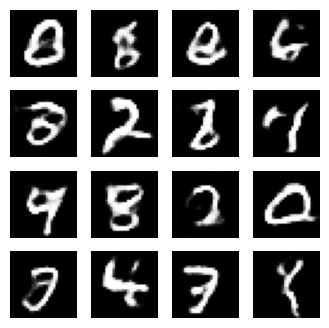

Time taken to process epoch 22 was 57.294724464416504 seconds


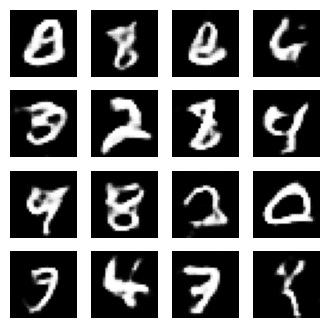

Time taken to process epoch 23 was 57.00981521606445 seconds


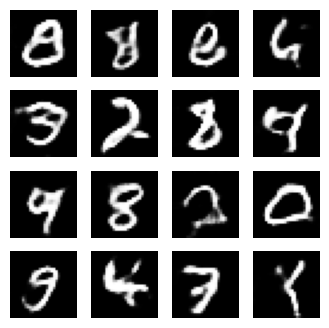

Time taken to process epoch 24 was 57.090595722198486 seconds


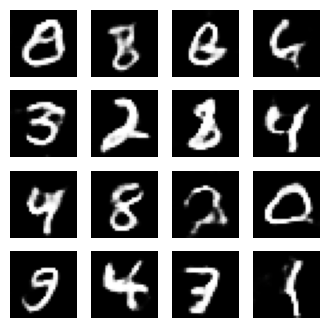

Time taken to process epoch 25 was 56.936797857284546 seconds


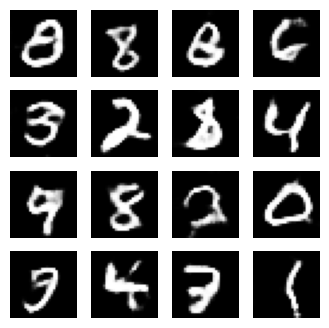

Time taken to process epoch 26 was 57.03466534614563 seconds


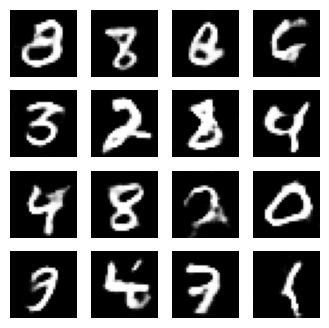

Time taken to process epoch 27 was 57.26293206214905 seconds


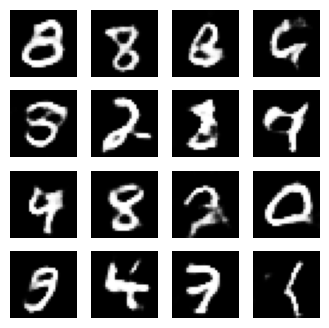

Time taken to process epoch 28 was 56.97094678878784 seconds


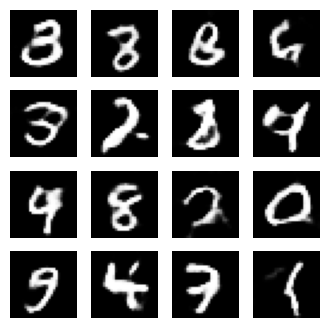

Time taken to process epoch 29 was 56.95920419692993 seconds


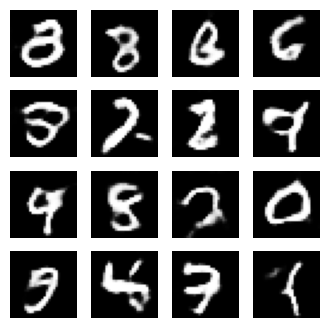

Time taken to process epoch 30 was 57.23788523674011 seconds


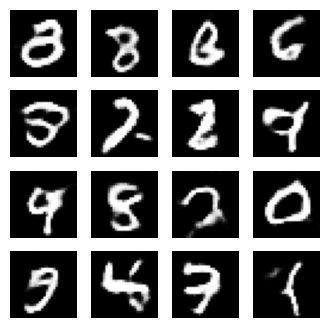

In [ ]:
train(X_train, epochs)